In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [2]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3

In [3]:
dataset = np.load('../../car_64.npy')


1553596416


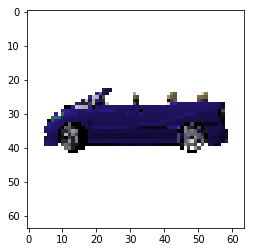

In [4]:
print(dataset.nbytes)
plt.imshow(dataset[711]/255)
plt.show()

In [5]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [6]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [7]:
del dataset
dataset_train.nbytes

1242611712

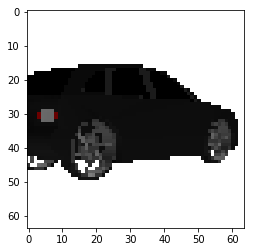

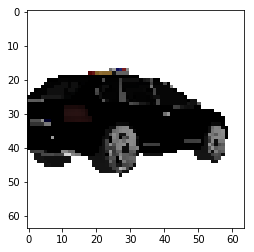

In [8]:
plt.imshow(dataset_train[1023]/255)
plt.show()
plt.imshow(dataset_test[1023]/255)
plt.show()

In [9]:
train_pairs = []
start_pose = [0]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [0]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [10]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(1, 0, 1)
(1, 0, 1)
(1907, 0, 21)
(167, 0, 1)


(811, 0, 6)
(503, 0, 9)
98315


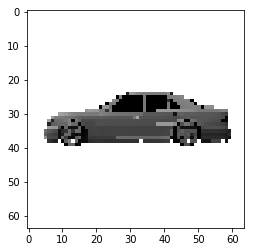

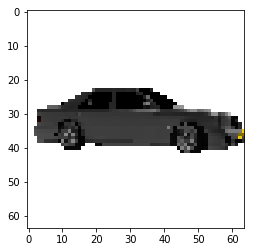

In [11]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(10*36) + 27]
j = dataset_train[(10*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [12]:
def normalize(data):
    data *= 2.0
    data /= 255.0
    data -= 1.0
    return data

def denormalize(data):
    data = data + 1.0
    data = data * 255.0
    data = data / 2.0
    return data

In [13]:
c = 0
for p in train_pairs:
    if p[0] == 12 and p[1] == 0:
        c += 1
print(c)

35


In [14]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
        cur_pose =  np.zeros(36, dtype='uint8')
        cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
        pose.append(np.broadcast_to(cur_pose,(8,8,36)))
        
    batch = np.array(batch, dtype=np.float64)
    batch_labels = np.array(batch_labels, dtype=np.float64)
    pose = np.array(pose, dtype=np.float64)
    
    #normalize
    batch = normalize(batch)
    batch_labels =  normalize(batch_labels)
    
    return batch,batch_labels,pose

batch, batch_labels, pose_labels = get_batch_data(train_pairs[36:72])

(36, 64, 64, 3) (36, 64, 64, 3) (36, 8, 8, 36)
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
<class 'numpy.float64'>
1.0 -1.0


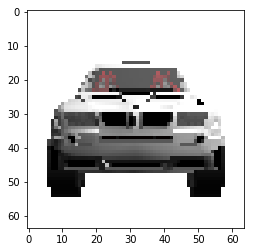

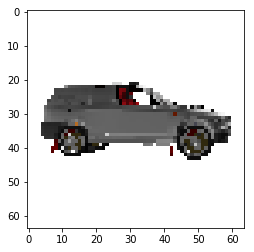

In [15]:
print(batch.shape, batch_labels.shape, pose_labels.shape)

t = 27
print(pose_labels[t][0][0])

print(type(batch_labels[t][0][0][0]))

print(np.max((batch[t])), np.min((batch[t])))

plt.imshow(denormalize(batch[t]) / 255)
plt.show()
plt.imshow(denormalize(batch_labels[t]) / 255)
plt.show()


In [16]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=lrelu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=lrelu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    return tf.reduce_mean(loss)

def local_moment_loss(pred, gt):
    with tf.name_scope('local_moment_loss'):

        ksz, kst = 4, 2
        local_patch = tf.ones((ksz, ksz, 1, 1))
        c = pred.get_shape()[-1]

        # Normalize by kernel size
        pr_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = (pr_var - tf.square(pr_mean)/(ksz**2)) / (ksz ** 2)
        pr_mean = pr_mean / (ksz ** 2)

        gt_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = (gt_var - tf.square(gt_mean)/(ksz**2)) / (ksz ** 2)
        gt_mean = gt_mean / (ksz ** 2)

        # scaling by local patch size
        local_mean_loss = tf.reduce_mean(tf.abs(pr_mean - gt_mean))
        local_var_loss = tf.reduce_mean(tf.abs(pr_var - gt_var))
    return local_mean_loss + local_var_loss
    

In [22]:
tf.reset_default_graph()

In [23]:
batch_size = 36
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, 8, 8, 36), name="pose")

disc_inputs = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")

real_label = tf.placeholder(tf.float32, [batch_size, 1])
fake_label = tf.placeholder(tf.float32, [batch_size, 1])

In [24]:
ae_reuse= False
disc_reuse = False

#generate coarse images from inputs_
def auto_encoder(inputs_, pose_):
    #print(inputs_)
    global ae_reuse
    with tf.variable_scope('encoder', reuse=ae_reuse):
        ae_reuse = True
        _ = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=lrelu)
        _ = tf.concat([pose_, _], 3)

        #_ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv1',act=lrelu)
        #_ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv_64_1',act=lrelu)
        #_ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv1',act=lrelu)
        #_ = batch_norm(_, True)
        #_ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv2',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv2',act=lrelu)
        #_ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv3',act=lrelu)
        #_ = tf.sigmoid(_)
        _ = tf.tanh(_)
    return _ 
    
    
# discriminator should give a fc layer
def discriminator(inputs_):
    global disc_reuse 
    with tf.variable_scope('dis', reuse=disc_reuse):
        disc_reuse = True
        ''' 
        _ = conv2d(inputs_, 4, 2, 32, 'conv1')
        _ = leaky_relu(_)
        _ = conv2d(_, 4, 2, 64, 'conv2')
        _ = batch_norm(_)
        _ = leaky_relu(_)
        _ = conv2d(_, 4, 2, 128, 'conv3')
        _ = batch_norm(_)
        _ = leaky_relu(_)
        _ = tf.reshape(_, [-1, 4 * 4 * 128])
        _ = fc(_, 1, 'fc4')
        print(_.get_shape(), "FC - Result")
        '''
        
        _ = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv1", act=lrelu)
        print(_.get_shape())
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv2", act=lrelu)
        _ = batch_norm(_, True)
        _ = tf.nn.dropout(_, keep_prob = 0.5, name='dis_drop_1')
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv3", act=lrelu)
        _ = batch_norm(_, True)
        _ = tf.nn.dropout(_, keep_prob = 0.5, name='dis_drop_2')
        _ = tf.reshape(_, [-1, 8 * 8 * 32])        
        _ = fc(_, 1, 'dis_fc1')
        o1 = tf.nn.sigmoid(_)
        o2 = _
        return o1, o2


In [25]:
global_step = tf.Variable(0,trainable=False)
lr = 5e-4

In [26]:
alpha = 0.2 #0.2
beta = 1.0 #1.0

'''
generated_images = auto_encoder(inputs_, pose_)
a1, dis_fake_samples_op = discriminator(generated_images)
a2, dis_real_samples_op = discriminator(disc_inputs)

print(dis_fake_samples_op.get_shape())

gen_loss_op = (alpha * ce_loss(fake_label, dis_fake_samples_op)) + (beta * l1_loss(generated_images, targets_))
dis_loss_op = ce_loss(fake_label, dis_fake_samples_op) + ce_loss(real_label, dis_real_samples_op)
'''



generated_images = auto_encoder(inputs_, pose_)
noise = np.random.normal(0, 0.2, inputs_.get_shape()).astype(np.float32)
generated_noise = auto_encoder(noise, pose_)

dreal, dreal_logits = discriminator(disc_inputs)
dfake, dfake_logits = discriminator(generated_images)
dnoise, dnoise_logits = discriminator(generated_noise)


dreal_labels = tf.zeros_like(dreal, dtype=tf.float32)
dfake_labels = 0.98 * tf.ones_like(dfake, dtype=tf.float32)

dreal_loss = ce_loss(dreal_labels, dreal_logits) + 0.2 * ce_loss(dfake_labels, dnoise_logits)
dfake_loss = ce_loss(dfake_labels, dfake_logits)# + 
dis_loss_op = dreal_loss + dfake_loss 


#gan_loss = alpha * ce_loss(tf.zeros_like(dfake), dfake_logits)
gan_loss = alpha * ce_loss(tf.ones_like(dfake), dfake_logits)
supervised_loss = beta * l1_loss(generated_images, targets_)
#supervised_loss = beta * local_moment_loss(generated_images, targets_)
gen_loss_op = gan_loss + supervised_loss


# Build Loss
#gen_loss_op = -tf.reduce_mean(tf.log(dis_fake_samples_op))
#dis_loss_op = -tf.reduce_mean(tf.log(dis_real_samples_op) + tf.log(1. - dis_fake_samples_op))

# Build Optimizers
#optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
#optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)




(36, 32, 32, 16)
(36, 32, 32, 16)
(36, 32, 32, 16)


In [ ]:
disriminator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
generator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
#print (generator_vars)
#dis_optimizer = tf.train.RMSPropOptimizer(lr)
#dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)
#gen_optimizer = tf.train.RMSPropOptimizer(lr)
#gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)


#dis_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)
#gen_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)
dlr = 1e-3#1e-4
glr = 5e-3#5e-4

dis_optimizer = tf.train.AdamOptimizer(dlr)
dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)

gen_optimizer = tf.train.AdamOptimizer(glr)
gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)

Step 1000: dis loss = 0.1320, gen loss = 0.1791, real_label_loss = 0.0223, fake_label_loss = 0.1096
Step 2000: dis loss = 0.1235, gen loss = 0.1419, real_label_loss = 0.0206, fake_label_loss = 0.1029
Epoch 0: dis loss = 0.1207, gen loss = 0.1256, real_label_loss = 0.0205, fake_label_loss = 0.1002


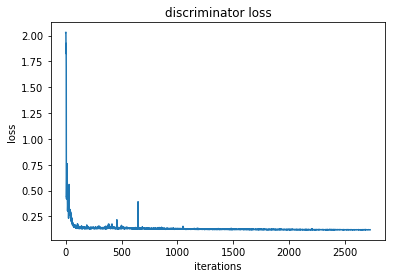

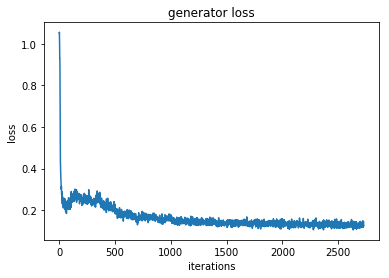

Step 3000: dis loss = 0.1200, gen loss = 0.1436, real_label_loss = 0.0203, fake_label_loss = 0.0996
Step 4000: dis loss = 0.1194, gen loss = 0.1103, real_label_loss = 0.0201, fake_label_loss = 0.0993
Step 5000: dis loss = 0.1185, gen loss = 0.1181, real_label_loss = 0.0198, fake_label_loss = 0.0986
Epoch 1: dis loss = 0.1187, gen loss = 0.1174, real_label_loss = 0.0199, fake_label_loss = 0.0988


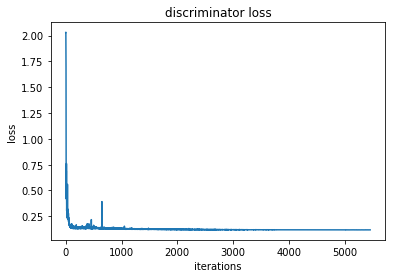

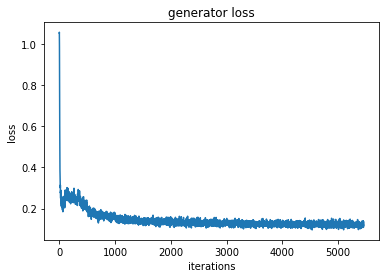

Step 6000: dis loss = 0.1186, gen loss = 0.1158, real_label_loss = 0.0198, fake_label_loss = 0.0988
Step 7000: dis loss = 0.1184, gen loss = 0.1106, real_label_loss = 0.0198, fake_label_loss = 0.0986
Step 8000: dis loss = 0.1180, gen loss = 0.1187, real_label_loss = 0.0197, fake_label_loss = 0.0983
Epoch 2: dis loss = 0.1181, gen loss = 0.1136, real_label_loss = 0.0197, fake_label_loss = 0.0984


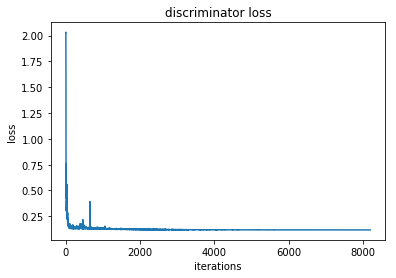

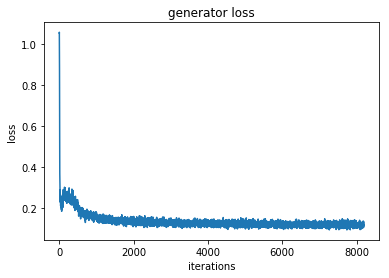

Step 9000: dis loss = 0.1181, gen loss = 0.1046, real_label_loss = 0.0197, fake_label_loss = 0.0983
Step 10000: dis loss = 0.1181, gen loss = 0.1015, real_label_loss = 0.0197, fake_label_loss = 0.0983
Epoch 3: dis loss = 0.1180, gen loss = 0.1105, real_label_loss = 0.0197, fake_label_loss = 0.0983


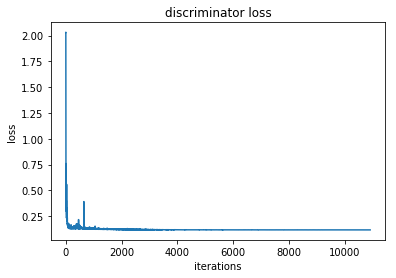

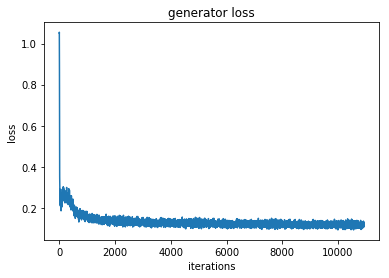

Step 11000: dis loss = 0.1180, gen loss = 0.1171, real_label_loss = 0.0197, fake_label_loss = 0.0983
Step 12000: dis loss = 0.1180, gen loss = 0.1207, real_label_loss = 0.0197, fake_label_loss = 0.0983
Step 13000: dis loss = 0.1179, gen loss = 0.0981, real_label_loss = 0.0197, fake_label_loss = 0.0982
Epoch 4: dis loss = 0.1180, gen loss = 0.1082, real_label_loss = 0.0197, fake_label_loss = 0.0983


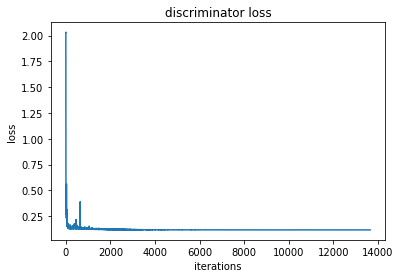

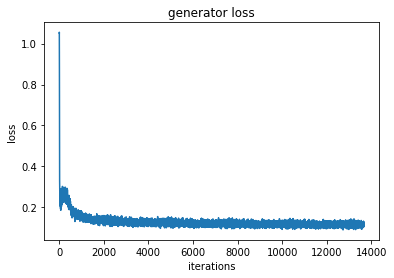

Step 14000: dis loss = 0.1181, gen loss = 0.1134, real_label_loss = 0.0197, fake_label_loss = 0.0984
Step 15000: dis loss = 0.1179, gen loss = 0.1211, real_label_loss = 0.0197, fake_label_loss = 0.0983
Step 16000: dis loss = 0.1180, gen loss = 0.1206, real_label_loss = 0.0197, fake_label_loss = 0.0983
Epoch 5: dis loss = 0.1180, gen loss = 0.1082, real_label_loss = 0.0197, fake_label_loss = 0.0984


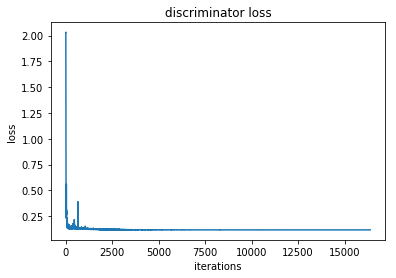

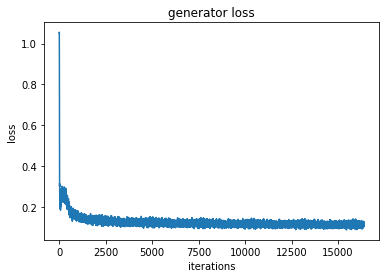

Step 17000: dis loss = 0.1179, gen loss = 0.1186, real_label_loss = 0.0197, fake_label_loss = 0.0982
Step 18000: dis loss = 0.1179, gen loss = 0.1059, real_label_loss = 0.0197, fake_label_loss = 0.0982
Step 19000: dis loss = 0.1179, gen loss = 0.1097, real_label_loss = 0.0196, fake_label_loss = 0.0982
Epoch 6: dis loss = 0.1179, gen loss = 0.1069, real_label_loss = 0.0196, fake_label_loss = 0.0983


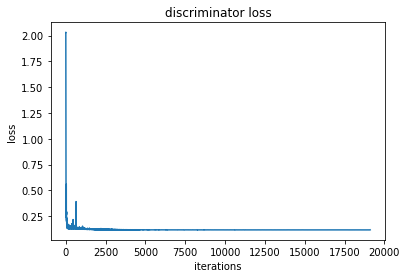

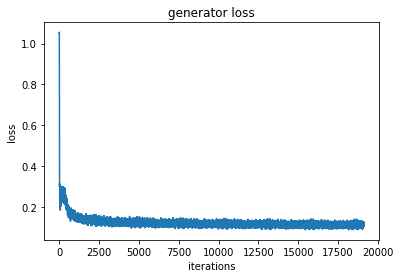

Step 20000: dis loss = 0.1179, gen loss = 0.1062, real_label_loss = 0.0197, fake_label_loss = 0.0983
Step 21000: dis loss = 0.1178, gen loss = 0.1011, real_label_loss = 0.0196, fake_label_loss = 0.0982
Epoch 7: dis loss = 0.1178, gen loss = 0.1068, real_label_loss = 0.0196, fake_label_loss = 0.0982


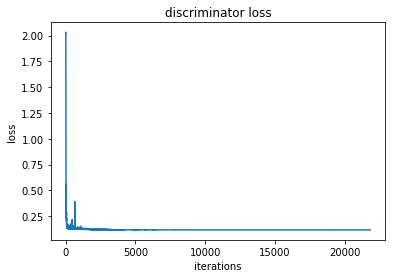

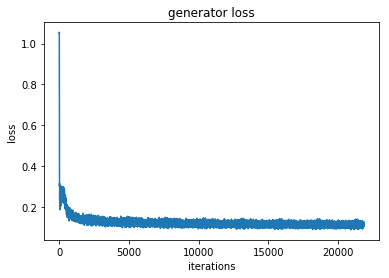

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 10
total_images = len(train_pairs)
step = 0

r = total_images // batch_size
l = len(dataset_train) // batch_size
#print(data_train.shape, "X1")
#d_inputs = data_train[399*batch_size : (400)*batch_size]
#print(d_inputs.shape, "X2")

#smooth_factor = 0.95
#plot_dis_s = 0
#plot_gen_s = 0
#plot_ws = 0

dis_losses = []
gen_losses = []

for epoch in range(epochs):
    for ii in range(r):
        step += 1
        zeros = np.zeros([batch_size, 1])* ((np.random.random_sample() *0.4) - 0.2)
        ones = np.ones([batch_size, 1]) * ((np.random.random_sample() *0.4) + 0.8)
        
        #batch = data_train[ii*batch_size : (ii+1)*batch_size]
        #batch_labels = train_labels[ii*batch_size : (ii+1)*batch_size]
        #pose_labels = pose[ii*batch_size : (ii+1)*batch_size]
        
        d_pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels, pose_labels = get_batch_data(d_pairs)
        #batch = normalize(batch)
        #batch_labels = normalize(batch_labels)
        
        '''
        print(pose_labels[0][0][0])
        plt.imshow(batch[0])
        plt.show()
        plt.imshow(batch_labels[0])
        plt.show()
        '''
        
        k = np.random.randint(1,l-1)
        d_inputs = dataset_train[k*batch_size : (k+1)*batch_size]
        
        
        '''
        #gen_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
        #                 fake_label: zeros}
        gen_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                         fake_label: zeros}
        _, gen_loss = sess.run([gen_train_op, gen_loss_op], feed_dict = gen_feed_dict)
        
        
        #if step % 5 == 0:
        dis_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                             fake_label: zeros, real_label: ones, disc_inputs: d_inputs}
        _, dis_loss = sess.run([dis_train_op, dis_loss_op], feed_dict = dis_feed_dict)
        '''
            
        
        
        feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                    fake_label: zeros, real_label: ones, disc_inputs: d_inputs}
        fetch_val = [gen_loss_op, dis_loss_op, dreal_loss, dfake_loss]
        
        if step % 5:
            fetch_val.append(gen_train_op)
        else:
            fetch_val.append(dis_train_op)
        
        gen_loss, dis_loss, _real, _fake, _ = sess.run(fetch_val, feed_dict = feed_dict)
        
        #plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
        #plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
        #plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
        dis_losses.append(dis_loss)
        gen_losses.append(gen_loss)

        if step % 1000 == 0:
            print('Step {0}: dis loss = {1:.4f}, gen loss = {2:.4f}, real_label_loss = {3:.4f}, fake_label_loss = {4:.4f}'.format(step, dis_loss, gen_loss, _real, _fake))
            
    print('Epoch {0}: dis loss = {1:.4f}, gen loss = {2:.4f}, real_label_loss = {3:.4f}, fake_label_loss = {4:.4f}'.format(epoch, dis_loss, gen_loss, _real, _fake))
    plt.plot(dis_losses)
    plt.title('discriminator loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

    plt.plot(gen_losses)
    plt.title('generator loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

In [ ]:
dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
saver = tf.train.Saver(dis_var_list + gen_var_list)
saver.save(sess, 'model/dcgan_pose_car_op_one_pose')

In [169]:
d_pairs = test_pairs[5 * batch_size : 6 * batch_size]
test_batch, test_labels, test_pose = get_batch_data(d_pairs, False)

In [170]:
feed_dict = { inputs_: test_batch, pose_: test_pose}
op = sess.run([generated_images], feed_dict = feed_dict)

In [171]:
j = 20
op = denormalize(op[0])



In [172]:
#op = op.astype(np.uint8)
print(np.min(op), np.max(op))
#print(np.where(op < -0.00001 ))

#print(op[0][0][59])

0.00151992 255.0


In [173]:
op = np.where(op < 0.0,0.0, op)

In [174]:
print(np.min(op), np.max(op))

0.00151992 255.0


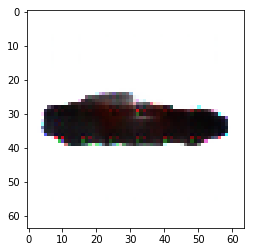

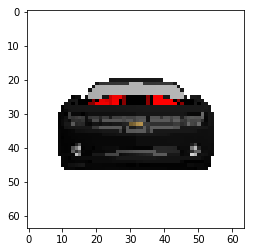

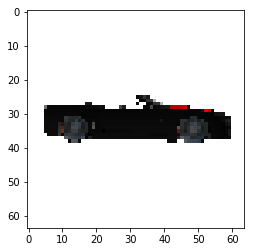

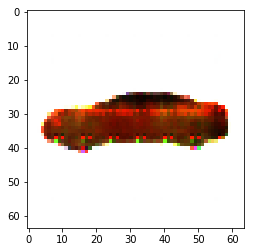

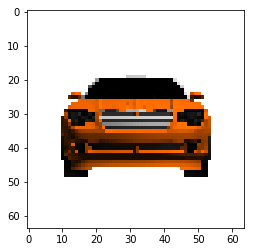

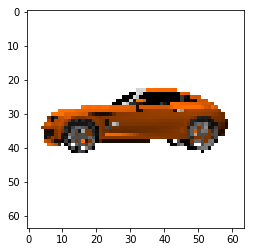

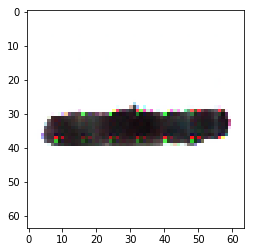

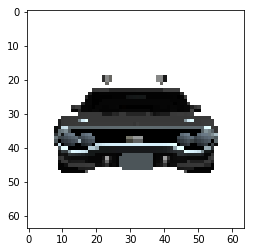

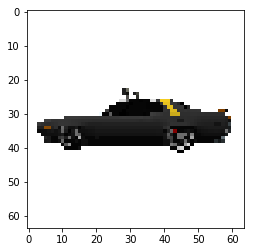

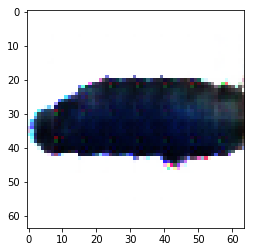

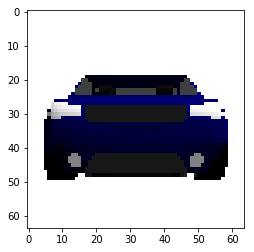

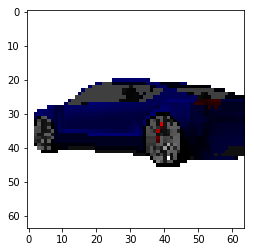

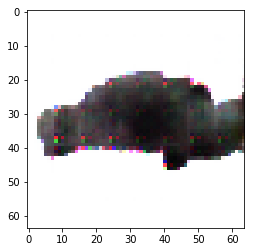

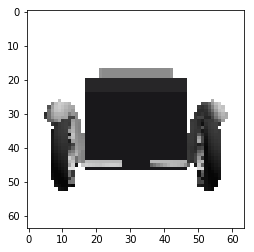

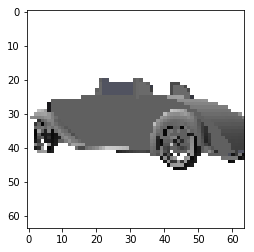

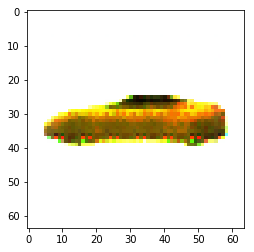

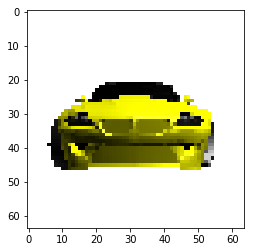

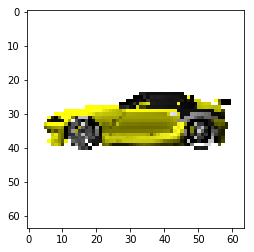

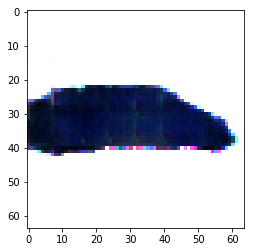

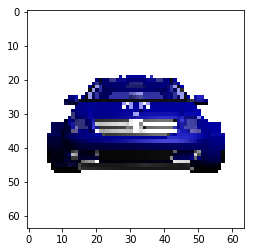

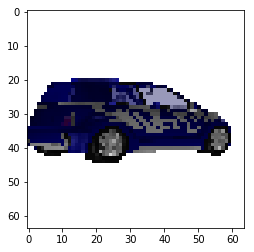

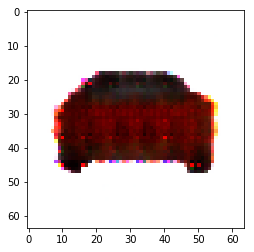

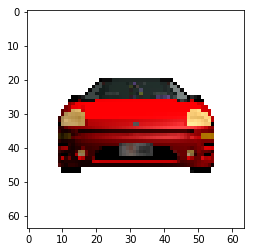

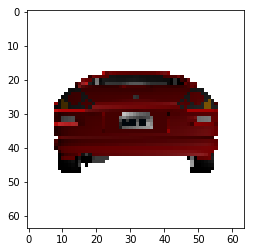

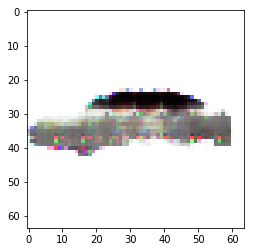

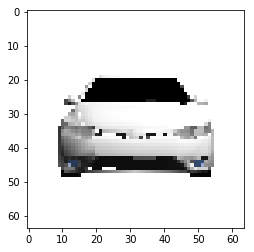

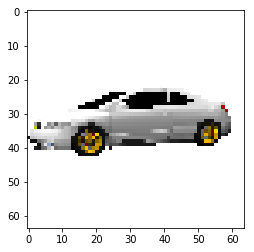

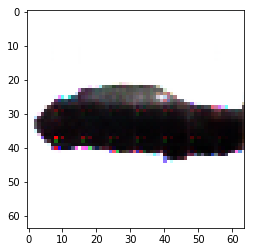

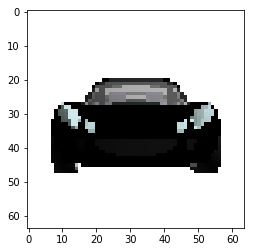

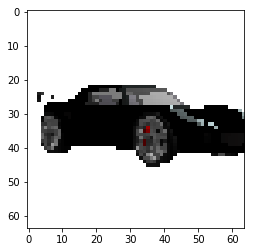

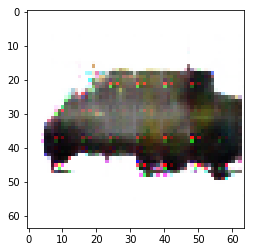

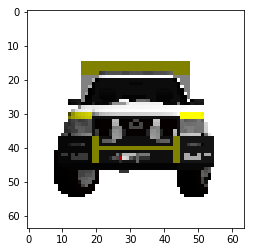

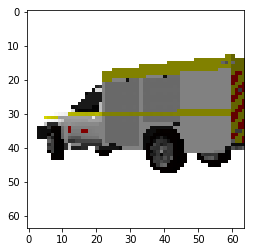

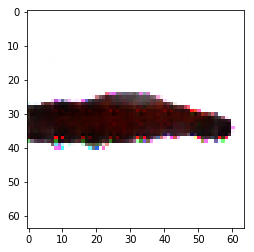

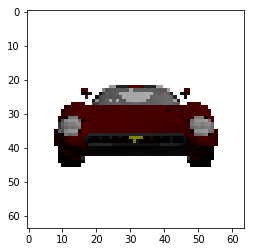

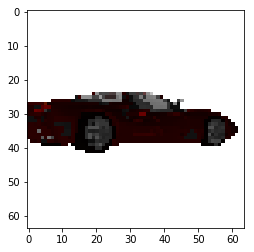

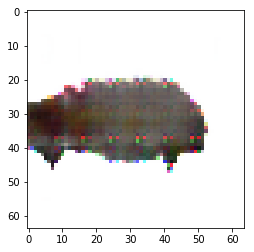

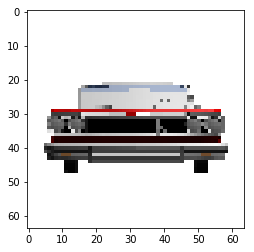

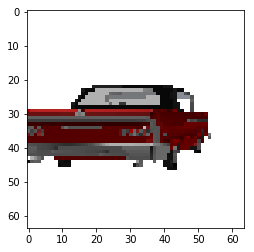

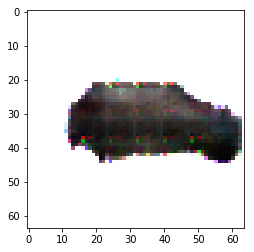

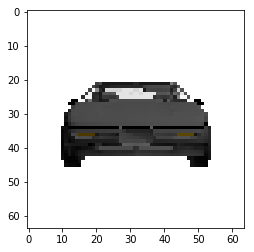

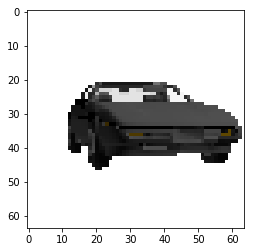

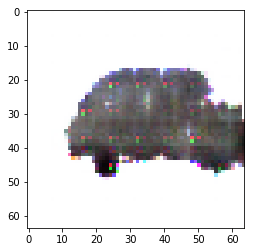

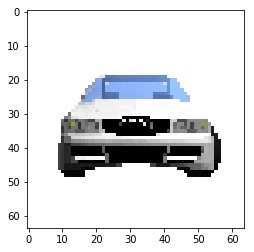

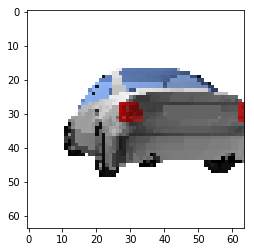

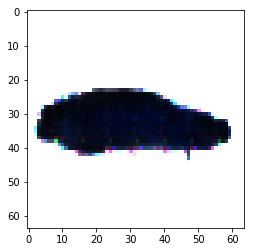

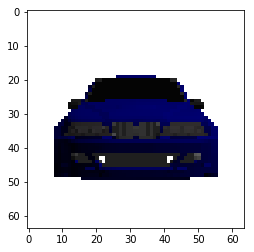

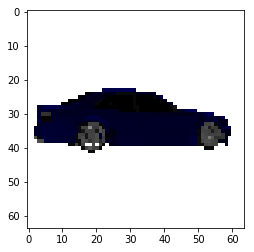

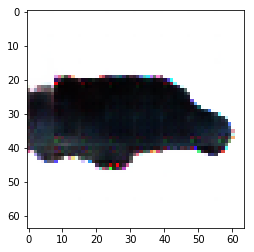

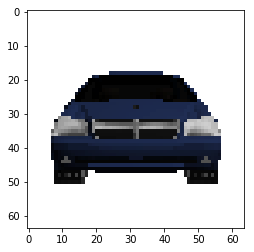

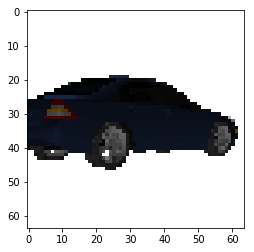

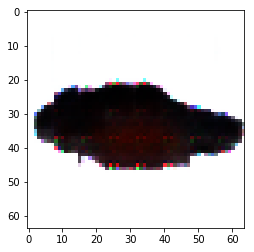

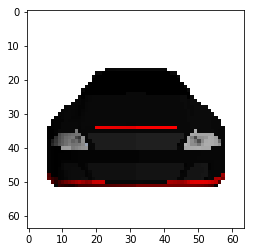

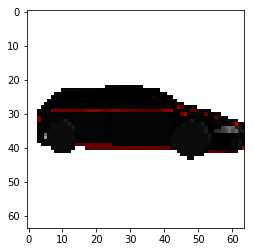

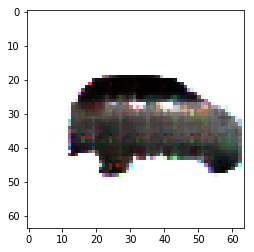

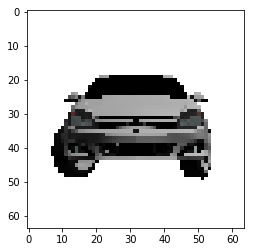

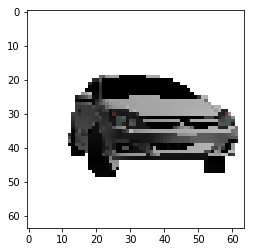

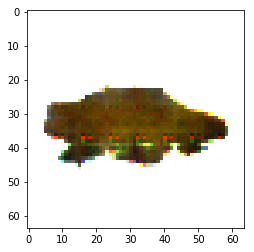

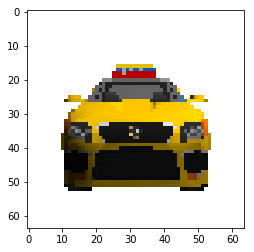

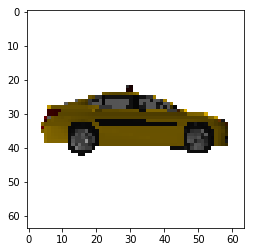

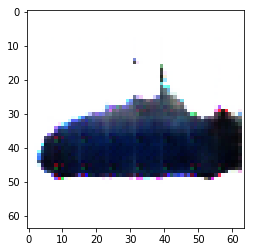

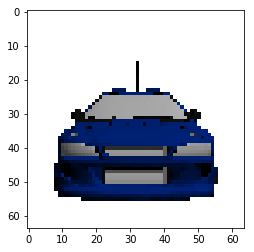

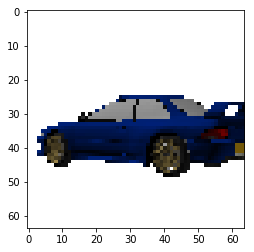

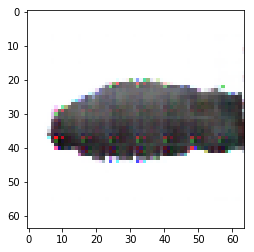

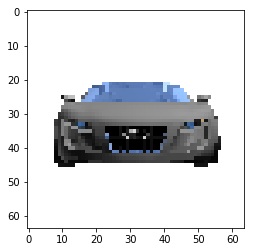

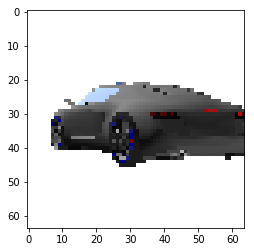

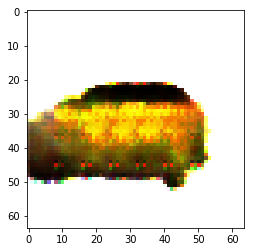

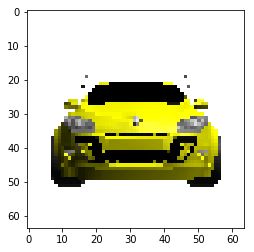

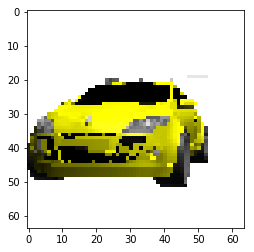

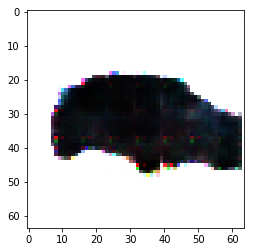

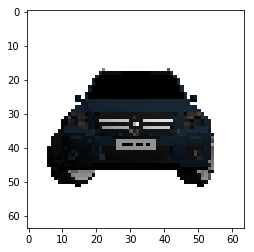

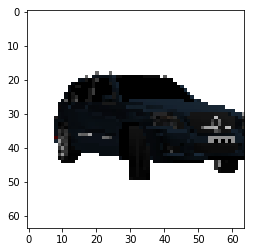

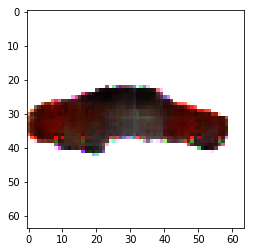

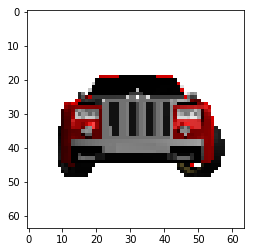

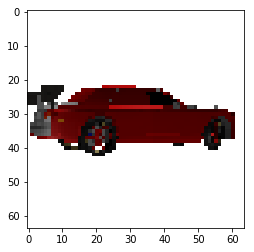

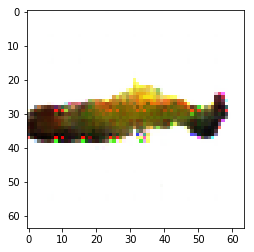

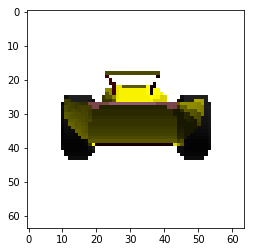

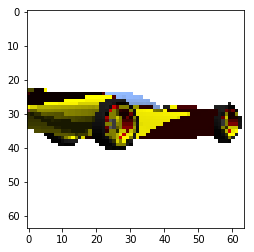

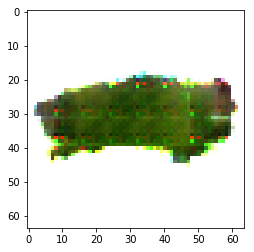

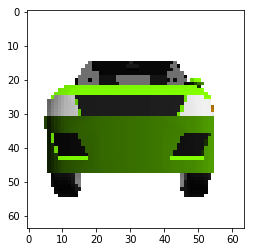

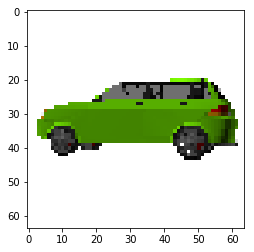

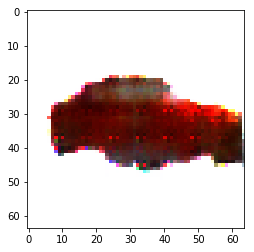

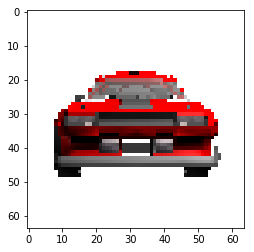

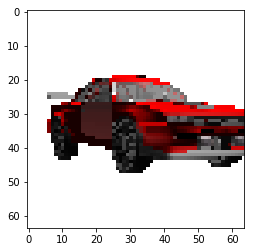

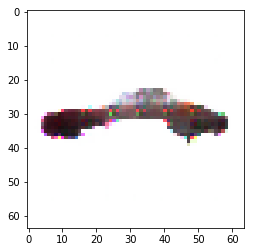

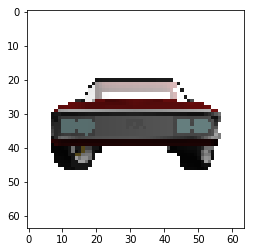

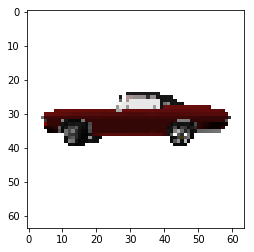

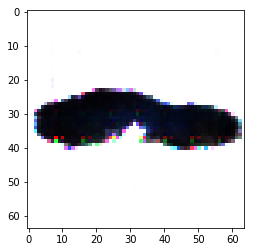

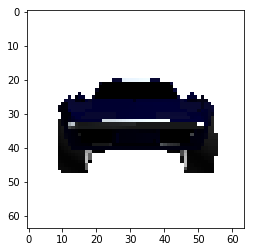

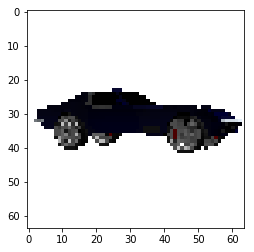

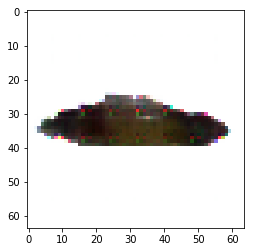

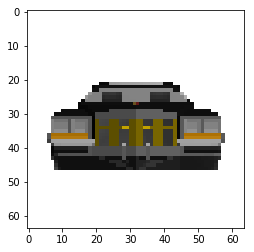

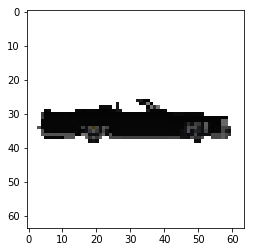

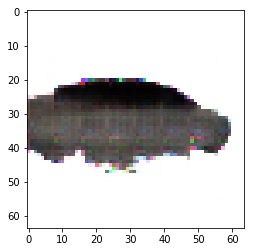

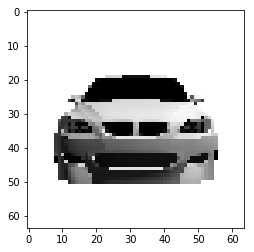

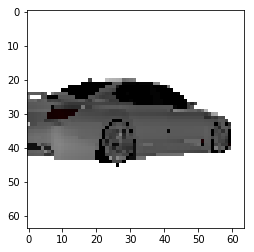

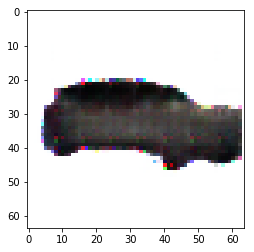

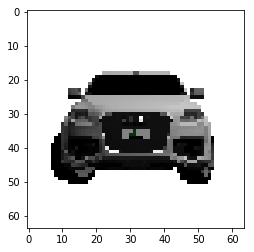

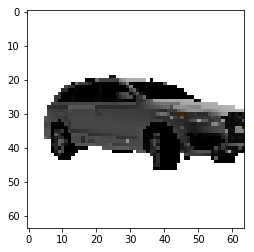

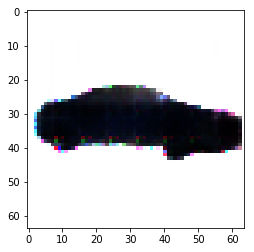

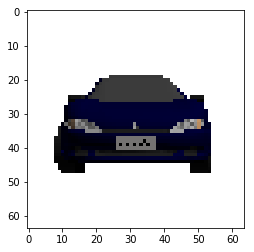

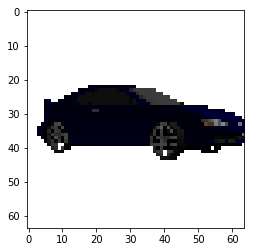

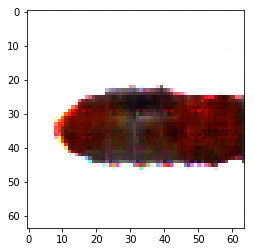

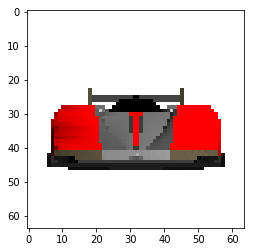

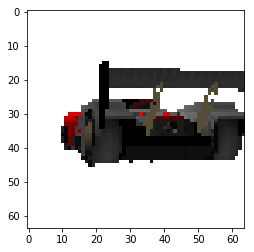

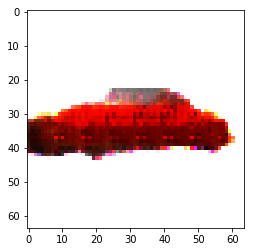

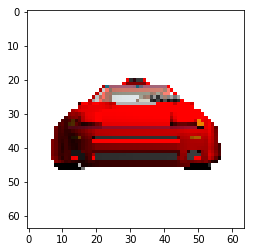

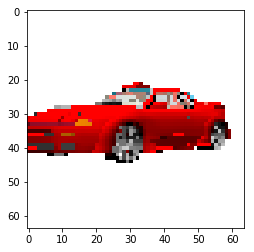

In [175]:
for j in range(batch_size):
    tmp = op[j]
    plt.imshow(tmp / 255)
    plt.show()

    plt.imshow(denormalize(test_batch[j])/255)
    plt.show()

    plt.imshow(denormalize(test_labels[j])/255)
    plt.show()